In [2]:
import pandas as pd 
import numpy as np 
from scipy.stats import gmean
import matplotlib.pyplot as plt
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
def followers_prob(mu, Q, V, ub):
    # n: number of assets
    # mu: expected returns (nx1)
    # Q: expected covariance (nxn)
    # V: maximum variance
    # ub: upper bound (nx1) 

    n = len(mu)
    x = cp.Variable(n)
    Z = cp.Parameter()

    obj = cp.Maximize(mu.T @ x)
    const = [cp.quad_form(x, Q) <= Z,
                np.ones([1, n]) @ x == 1,
                x >= 0,
                x <= ub]
    prob = cp.Problem(obj, const)
    assert prob.is_dpp()

    cvxpylayer = CvxpyLayer(prob, parameters=[Z], variables=[x])
    
    Z_tch = V.clone().detach().requires_grad_(True)
    solution, = cvxpylayer(Z_tch)

    return solution

In [4]:
def get_lower_upper_var(Q, ub):
    # returns (L, U) for the variance to make it feasible
    K = 0.01 # increase chance of feasibility

    U = -float("inf")

    for index, val in enumerate(ub):
        if val and Q[index][index] > U:
            U = Q[index][index]

    n = len(Q)
    x = cp.Variable(n)

    obj = cp.Minimize(cp.quad_form(x, Q))
    const = [np.ones([1, n]) @ x == 1,
            x >= 0,
            x <= ub]
    
    prob = cp.Problem(obj, const)
    prob.solve(solver=cp.ECOS)
    L = prob.value*(1+K)

    return L, U

In [5]:
full_prices = pd.read_csv("../data/Equity_Prices_Full.csv", index_col=0)
full_prices.index = pd.to_datetime(full_prices.index)

sectors = {"Financials": ["ALL", "BAC", "C", "GS", "JPM"],
           "Information Technology": ["AAPL", "INTC", "MSFT", "IBM", "CSCO"],
           "Consumer Staples": ["KO", "COST", "PG", "WMT", "TGT"]}

tickers = np.ndarray.flatten(np.array(list(sectors.values())))
n = len(tickers)

full_prices = full_prices[tickers]

In [6]:
strategies = {} #key is trader ID, value is ub array (1 if allowed to invest)

strategies[0] = [1 if ticker in sectors["Financials"] else 0 for ticker in tickers]
strategies[1] = [1 if ticker in sectors["Information Technology"] else 0 for ticker in tickers]
strategies[2] = [1 if ticker in sectors["Consumer Staples"] else 0 for ticker in tickers]

In [7]:
subset_start_date = "2010-01-01"
subset_date = "2012-12-31"

subset_prices = full_prices.loc[subset_start_date:subset_date]
subset_returns = subset_prices.pct_change(1).iloc[1:, :]

training_returns = subset_returns.iloc[:-1,:]
test_returns = subset_returns.iloc[-1,:]

subset_prices.head()

,ALL,BAC,C,GS,JPM,AAPL,INTC,MSFT,IBM,CSCO,KO,COST,PG,WMT,TGT
Date,,,,,,,,,,,,,,,
2010-01-31,29.93,15.18,3.32,148.72,38.94,192.063,19.40,28.1800,122.39,22.47,54.25,57.43,61.55,53.43,51.27
2010-02-28,31.25,16.66,3.40,156.35,41.97,204.620,20.53,28.6700,127.16,24.33,52.72,60.97,63.28,54.07,51.52
2010-03-31,32.31,17.85,4.05,170.63,44.70,235.000,22.29,29.2875,128.25,26.03,55.00,59.71,63.27,55.60,52.60
2010-04-30,32.67,17.83,4.37,145.20,42.58,261.090,22.84,30.5350,129.00,26.93,53.45,59.08,62.16,53.64,56.87
2010-05-31,30.63,15.74,3.96,144.26,39.58,256.880,21.42,25.8000,125.26,23.16,51.40,58.25,61.09,50.56,54.53


In [8]:
mu = torch.tensor(gmean(training_returns + 1)-1)
Q = torch.tensor(np.cov(training_returns.T))

print(mu.shape)
print(Q.shape)

# check for PSD
assert min(np.linalg.eigvals(Q.numpy()) > 1e-9)

torch.Size([15])
torch.Size([15, 15])


In [9]:
class PortfolioOptimizationModel(nn.Module):
    def __init__(self, total_budget, N, mu, Q, risk_coeff, strategies, learning_rate):
        super(PortfolioOptimizationModel, self).__init__()
        self.total_budget = total_budget
        self.N = N
        self.mu = mu
        self.Q = Q
        self.risk_coeff = risk_coeff
        self.strategies = strategies
        self.L, self.U = self.initialize_lower_upper()
        self.learning_rate = learning_rate

        # Decision variables
        self.Z = nn.Parameter(self.initialize_Z())
        self.B = nn.Parameter(torch.full((N,), total_budget / N, requires_grad=True))

        # Slack variable
        self.slack_var = torch.full((N * 3 + 2,), 1.0)

    def initialize_lower_upper(self):
        L, U = [], []
        for i in range(self.N):
            lower, upper = get_lower_upper_var(self.Q, self.strategies[i])
            L.append(lower)
            U.append(upper)
        return L, U

    def initialize_Z(self):
        Z = torch.tensor([(upper + lower) / 2 for lower, upper in zip(self.L, self.U)], requires_grad=True)
        return Z

    def forward(self, update_slack=False) -> torch.Tensor:
        overall_holdings = torch.zeros_like(self.mu)

        for i in range(3):
            x = followers_prob(self.mu, self.Q, self.Z[i], self.strategies[i])
            overall_holdings += (self.B[i] * x)
        
        if update_slack:
            gradient = self.get_slack_gradient(overall_holdings)
            with torch.no_grad():  
                self.slack_var.data.add_(gradient*self.learning_rate) 
                self.slack_var.data = torch.max(self.slack_var.data, torch.tensor(0.0)) 

        # Calculate the Lagrangian
        gradient = self.get_slack_gradient(overall_holdings)
        total_reward = -torch.matmul(self.mu.T, overall_holdings)
        L = total_reward + torch.matmul(self.slack_var, gradient)

        return L

    def get_slack_gradient(self, overall_holdings) -> torch.Tensor:
        gradient = torch.ones([self.N * 3 + 2])
        gradient[0] = (torch.sum(self.B) - self.total_budget)

        for i in range(self.N):
            gradient[i + 1] = self.Z[i] - self.U[i]
            gradient[i + 1 + self.N] = -self.Z[i] + self.L[i]
            gradient[i + 1 + 2 * self.N] = -self.B[i]

        risk = torch.matmul(torch.matmul(overall_holdings.T, self.Q), overall_holdings) / (torch.sum(self.B) ** 2)
        gradient[1 + 3 * self.N] = risk - (self.risk_coeff * self.total_budget) ** 2

        return gradient

In [10]:
total_budget = 10000
N = 3 
risk_coeff = 0.1
learning_rate = 1

# Initialize slack variables at 1
model = PortfolioOptimizationModel(total_budget, N, mu, Q, risk_coeff, strategies, learning_rate)
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Z starts as average of L and U, B starts as equally distributed portfolio
print(f"Initial Z and B: {model.Z.data.numpy()} {model.B.data.numpy()}")

# Training loop
num_epochs = 100 # Adjust the number of epochs
plot_interval = 5  # Adjust the interval for plotting (every k epochs)
slack_update_interval = 9
lagrangian_values = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()

    # Update slack variables every slack_update_interval iterations
    if (epoch + 1) % slack_update_interval == 0:
        model.forward(update_slack=True)

    # Append Lagrangian value to the list
    lagrangian_values.append(loss.item())

    # Print or log the Lagrangian value every k epochs
    if (epoch + 1) % plot_interval == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Lagrangian: {loss.item()}')

# Access optimized values
print(f"Optimized Z and B: {model.Z.data.numpy()} {model.B.data.numpy()}")

Initial Z and B: [0.93796474 0.0052987  0.00539088] [3333.3333 3333.3333 3333.3333]
Epoch 5/100, Lagrangian: -1010349.0563334897


/var/folders/hl/gtp2tmts2nsg0_m68538_1jm0000gn/T/ipykernel_96677/773206333.py:12: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  obj = cp.Maximize(mu.T @ x)


Epoch 10/100, Lagrangian: -347.28170764443854
Epoch 15/100, Lagrangian: -348.9636435295422
Epoch 20/100, Lagrangian: -347.16398953832737
Epoch 25/100, Lagrangian: -347.1661393773119
Epoch 30/100, Lagrangian: -347.1682207845762
Epoch 35/100, Lagrangian: -347.1703706235607
Epoch 40/100, Lagrangian: -347.17245203268766
Epoch 45/100, Lagrangian: -347.17460187167217
Epoch 50/100, Lagrangian: -347.17668328079907
Epoch 55/100, Lagrangian: -347.17876468806344
Epoch 60/100, Lagrangian: -347.180914527048
Epoch 65/100, Lagrangian: -347.18299593617496
Epoch 70/100, Lagrangian: -347.1851457751594
Epoch 75/100, Lagrangian: -347.1872271842864
Epoch 80/100, Lagrangian: -347.1893770232709
Epoch 85/100, Lagrangian: -347.19145843239784
Epoch 90/100, Lagrangian: -347.19360827138235
Epoch 95/100, Lagrangian: -347.19568967864666
Epoch 100/100, Lagrangian: -347.1977710877737
Optimized Z and B: [0.93796474 0.0052987  0.00539088] [3332.886  3332.6907 3332.5198]


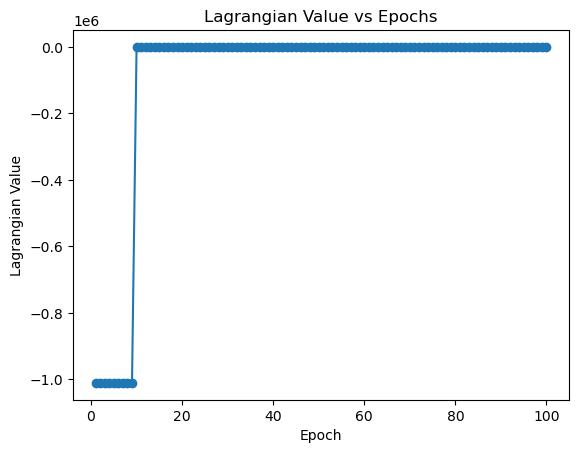

In [11]:
# Plotting the Lagrangian values
plt.plot(range(1, num_epochs + 1), lagrangian_values, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Lagrangian Value')
plt.title('Lagrangian Value vs Epochs')
plt.show()

In [12]:
print(list(model.parameters()))

[Parameter containing:
tensor([0.9380, 0.0053, 0.0054], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([3332.8860, 3332.6907, 3332.5198], requires_grad=True)]
